In [16]:
import pandas
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from scipy.signal import correlate, correlation_lags

In [17]:
def input_data(file_1, file_2):
    if file_1.__contains__('.csv'):
        df = pandas.read_csv(file_1)
    else:
        df = pandas.read_excel(file_1, sheet_name='Sheet1')
        
    if file_2.__contains__('.csv'):
        tdf = pandas.read_csv(file_2)
        tobii_left = tdf['left_r']
        tobii_right = tdf['right_r']
        # tobii_mean = tdf['mean']
    else:
        tdf = pandas.read_excel(file_2, index_col=1, sheet_name='Data')
        tdf = tdf.rename(columns={'Pupil diameter left [mm]': 'left_r', 'Pupil diameter right [mm]': 'right_r', 
                                 'Recording timestamp [ms]': 'time'})
        tdf = tdf[['time', 'left_r', 'right_r']].iloc[1:, :]
        # tobii_mean = []
        # for i, c in zip(tobii_left, tobii_right):
        #     tobii_mean.append(np.mean((i, c)))

    return df, tdf

file_1 = 'pupil_data_python_sun_new.csv'
file_2 = 'dark_video_tobii_sun.xlsx'
df, tdf = input_data(file_1, file_2)
video_len = 60+17 #second

In [18]:
# formalise the opencv data (into second)
# df = df[['time', 'left_r', 'right_r']]
s = df['time'][0]
avg_amount = (list(df['time'])[-1] - s)/video_len # calculate how many frames each second
df['time'] = [(i-s)/avg_amount for i in df['time']]
df = df.set_index('time')

In [19]:
#formalise eye tracker data (into second)
tdf['time'] = [i/1000 for i in tdf['time']]
tdf['left_r'] = [i/2 for i in tdf['left_r']]
tdf['right_r'] = [i/2 for i in tdf['right_r']]
tdf = tdf.set_index('time')

In [20]:
from collections import OrderedDict
def get_quartiles(arr):
    arr = [i for i in arr if not np.isnan(i)]
    arr = np.sort(arr)
    mid = int(len(arr)/2)
    if(len(arr)%2 == 0):
        Q1 = np.median(arr[:mid])
        Q3 = np.median(arr[mid:])
    else:
        Q1 = np.median(arr[:mid])
        Q3 = np.median(arr[mid:])
    return Q1,Q3

def eliminate_outliers(values, bias = 0.5):
    print('before', len(values))
    q1,q3 = get_quartiles(values)
    iqr = q3 - q1
    lowerLimit = q1 - bias*iqr
    upperLimit = q3 + bias*iqr
    print('lower', lowerLimit, q1, q3, 'upper', upperLimit)
    result = []
    for v in values:
        if v < lowerLimit or v > upperLimit: result.append(np.nan)
        else:
            result.append(v)
    print('after', len([i for i in result if i is not np.nan]), '\n')
    return result

before 4326
lower 4.084685325622559 4.5 6.576573371887207 upper 6.991888046264648
after 2912 

before 4326
lower 34.39534950256348 41.5 55.70930099487305 upper 62.81395149230957
after 3850 



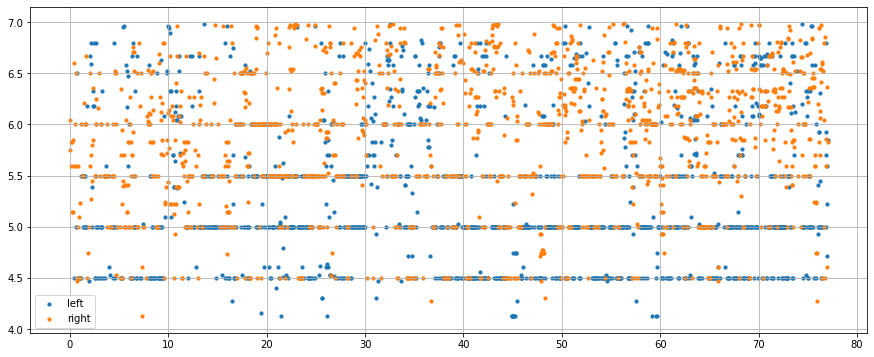

In [21]:
#remove by radius
values = np.concatenate( [list(df['left_r']), list(df['right_r'])] )
sep = len(df['left_r'])

values = eliminate_outliers(values, 0.2)
df['left_r'] = values[:sep]
df['right_r'] = values[sep:]

#remove by x coordinate
values = np.concatenate( [list(df['left_x']), list(df['right_x'])] )
sep = len(df['left_x'])

values = eliminate_outliers(values)
df['left_x'] = values[:sep]
df['right_x'] = values[sep:]

#plot left and right
fig, ax = plt.subplots(figsize=(15, 6))
ax.scatter(x=list(df.index), y=df['left_r'], s=10, label='left')
ax.scatter(x=list(df.index), y=df['right_r'], s=10, label='right')
ax.grid()
ax.legend(loc='best')

total valid radius 2910


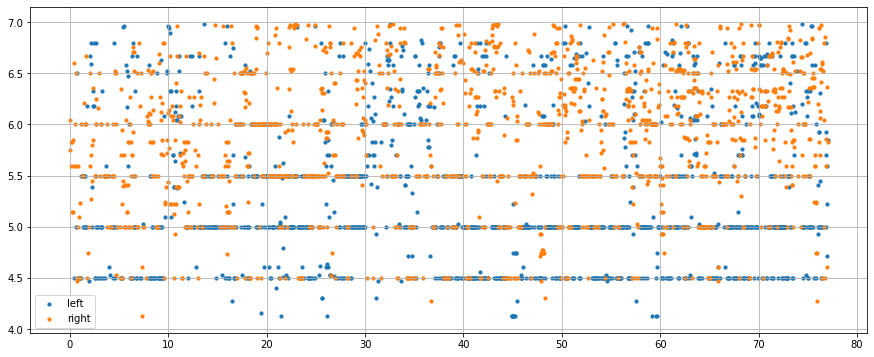

In [22]:
left_r = []
right_r = []
for i, r in df.iterrows():
    if r['left_x'] is np.nan:
        left_r.append(np.nan)
    else:
        left_r.append(r['left_r'])
        
    if r['right_x'] is np.nan:
        right_r.append(np.nan)
    else:
        right_r.append(r['right_r'])
        
df['left_r'] = left_r
df['right_r'] = right_r

#plot left and right
fig, ax = plt.subplots(figsize=(15, 6))
ax.scatter(x=list(df.index), y=df['left_r'], s=10, label='left')
ax.scatter(x=list(df.index), y=df['right_r'], s=10, label='right')
ax.grid()
ax.legend(loc='best')

print('total valid radius', len([i for i in left_r if not np.isnan(i)]) + len([i for i in right_r if not np.isnan(i)]))

## scatter plot of radius of eye_tracker

In [23]:
values = np.concatenate( [list(tdf['left_r']), list(tdf['right_r'])] )
sep = len(tdf['left_r'])

values = eliminate_outliers(values)
tdf['left_r'] = values[:sep]
tdf['right_r'] = values[sep:]

before 8776
lower 0.9475 0.985 1.06 upper 1.0975000000000001
after 7426 



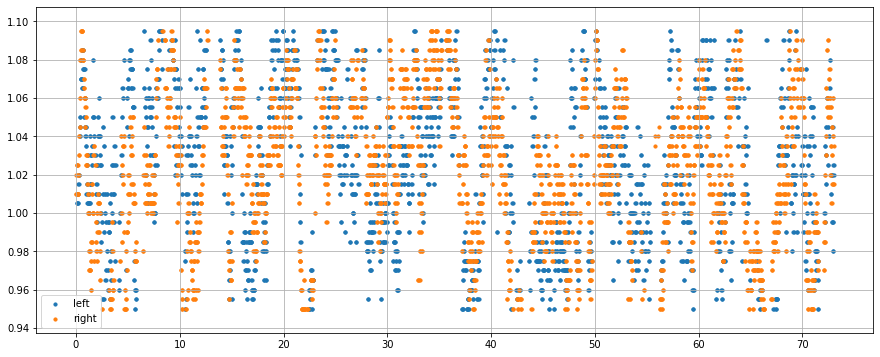

In [24]:
#plot left and right
fig, ax = plt.subplots(figsize=(15, 6))
ax.scatter(x=list(tdf.index), y=tdf['left_r'], s=10, label='left')
ax.scatter(x=list(tdf.index), y=tdf['right_r'], s=10, label='right')
ax.grid()
ax.legend(loc='best')

In [25]:
#merge left and right
def merge_both_side(df):
    result = []
    for i, r in df.iterrows():
        a = r['left_r']
        b = r['right_r']
        if a >= 11: a = np.nan
        if b >= 11: b = np.nan
        if a is not np.nan and b is not np.nan:
            result.append(np.mean((a, b)))
        elif a is not np.nan:
            result.append(a)
        elif b is not np.nan:
            result.append(b)
        else:
            result.append(np.nan)
    df['pupil'] = result
    df = df.drop(labels=['left_r', 'right_r'], axis=1)
    return df

In [26]:
merge_df = merge_both_side(df)
merge_tdf = merge_both_side(tdf)

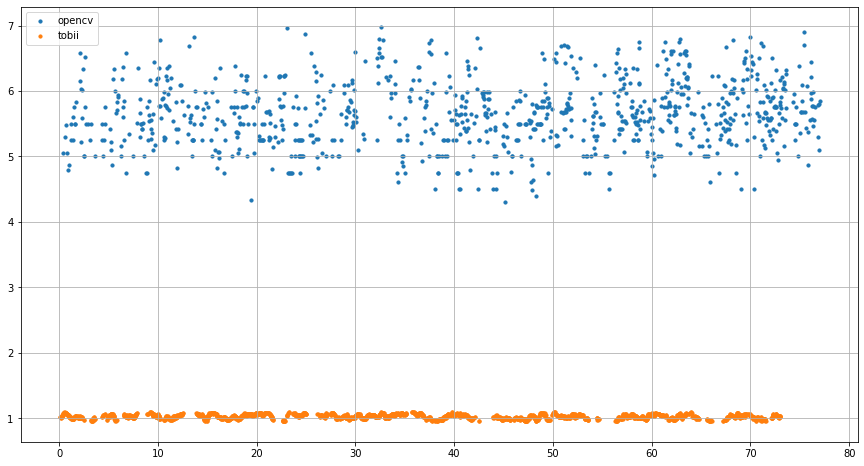

In [27]:
fig, ax = plt.subplots(figsize=(15, 8))

ax.scatter(x=list(merge_df.index), y=merge_df['pupil'], s=10, label='opencv')
ax.scatter(x=list(merge_tdf.index), y=merge_tdf['pupil'], s=10, label='tobii')

ax.grid()
ax.legend(loc='best')

## 1 second timeframe

In [28]:
def normalise_1_sec(df):
    result = {}
    values = []
    current_sec = 0
    for i, r in df.iterrows():
        k = i//1
        if k == current_sec:
            if r['pupil'] != 0 and not np.isnan(r['pupil']):
                values.append(r['pupil'])
        else:
            if len(values) == 0:
                if current_sec > 0:
                    result.update({current_sec: result[current_sec-1]}) #if no available value, then select the last one
                else:
                    result.update({current_sec: np.nan})
            else:
                result.update({current_sec: np.mean(values)})
                values = []
            current_sec += 1
            if r['pupil'] != 0 and not np.isnan(r['pupil']):
                values.append(r['pupil'])
    
    if np.isnan(result[0]):
        result.update({0: result.get(1)})
    return result

In [29]:
def cal_rate(ary): #pupil change rate
    result = []
    for a, b in zip(ary[:-2], ary[1:]):
        result.append( (b-a)/a )
    return result

In [30]:
def plot_rate(ary1, ary2, timeframe):
    ### plot
    total = 0 #total matching
    for i in range(min(len(ary2), len(ary1))-1):
        if ary1[i] >= ary1[i+1] and ary2[i] >= ary2[i+1]: total += 1
        elif ary1[i] <= ary1[i+1] and ary2[i] <= ary2[i+1]: total += 1

    print('total matching ', total, len(ary1)-1, len(ary2)-1, total/(len(ary1)-1), total/(len(ary2)-1))

    fig, (ax1, ax2) = plt.subplots(2, figsize=(15, 8))

    ax1.plot(ary1, label='eye_tracker')
    ax1.plot(ary2, label='opencv software')

    ax1.scatter(x=np.arange(len(ary1)), y=ary1, s=10, color='red')
    ax1.scatter(x=np.arange(len(ary2)), y=ary2, s=10, color='red')

    ax1.set_xlabel('time(per '+ str(timeframe) +' second)')
    ax1.set_ylabel('percentage changes in pupil size')
    ax1.grid()
    ax1.legend(loc='best')
    
    corr = correlate(ary1, ary2)
    lags = correlation_lags(len(ary1), len(ary2))
    corr /= np.max(corr)
    ax2.plot(lags, corr, label='cross-correlated signals')
    ax2.grid()
    
    print('The cross-correlation score is: ', sum(corr))
    
    import scipy.stats as stats       
    r, p = stats.pearsonr(np.arange(len(ary1)), ary1)
    print('pearson correlation of eye_tracker (r, p):', r, p)

    r, p = stats.pearsonr(np.arange(len(ary2)), ary2)
    print('pearson correlation of opencv software (r, p):', r, p)


[CHECK] df total  77  values for  76  second
[CHECK] tdf total  73  values for  72  second
total matching  30 69 73 0.43478260869565216 0.410958904109589
The cross-correlation score is:  -0.07851263122201099
pearson correlation of eye_tracker (r, p): 0.005366008750684648 0.9648349093556382
pearson correlation of opencv software (r, p): 0.0024593443980804614 0.9834084447951736


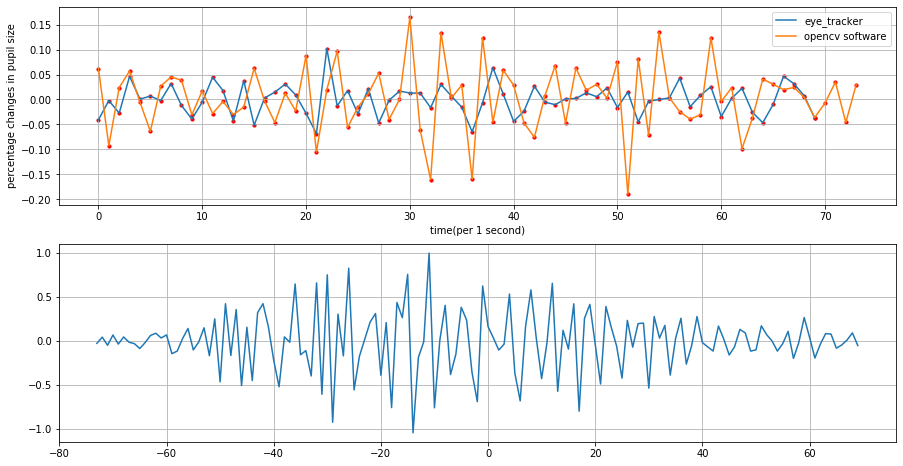

In [31]:
#normalise into 1 second timeframe
df_1 = normalise_1_sec(merge_df)
tdf_1 = normalise_1_sec(merge_tdf)
print('[CHECK] df total ', len(df_1.keys()), ' values for ', list(df_1.keys())[-1], ' second')
print('[CHECK] tdf total ', len(tdf_1.keys()), ' values for ', list(tdf_1.keys())[-1], ' second')
tb_rate_1 = cal_rate(list(tdf_1.values()))[:-1]
py_rate_1 = cal_rate(list(df_1.values()))[1:]
plot_rate(tb_rate_1, py_rate_1, 1)

## 2 second timeframe (1sec overlap)

In [32]:
def normalise_sec(df, sec=2): #input dict
    result = {}
    for i in range(0, len(df.keys())-(sec-1), (sec-1)):
        values = []
        for a in range(sec):
            v = df[i+a]
            if v is not None:
                values.append(v)
                
        if len(values) == 0:
            result.update({i: result[i-1]})
        else:
            result.update({i: np.mean(values)})
            
    return result

[CHECK] df total  76  values for  75  second
[CHECK] tdf total  72  values for  71  second
total matching  37 68 72 0.5441176470588235 0.5138888888888888
The cross-correlation score is:  0.017339354653761845
pearson correlation of eye_tracker (r, p): 0.0106840589270614 0.930568509598088
pearson correlation of opencv software (r, p): 0.012039639176706394 0.9194751263182686


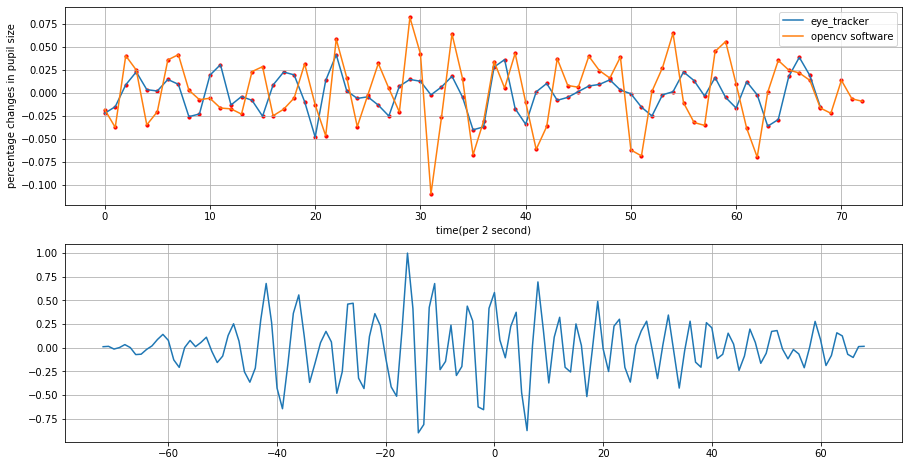

In [33]:
#normalise into 2 second timeframe
df_2 = normalise_sec(df_1)
tdf_2 = normalise_sec(tdf_1)
print('[CHECK] df total ', len(df_2.keys()), ' values for ', list(df_2.keys())[-1], ' second')
print('[CHECK] tdf total ', len(tdf_2.keys()), ' values for ', list(tdf_2.keys())[-1], ' second')
tb_rate_2 = cal_rate(list(tdf_2.values()))[:-1]
py_rate_2 = cal_rate(list(df_2.values()))[1:]
plot_rate(tb_rate_2, py_rate_2, 2)

## 3 second timeframe (1sec overlap)

[CHECK] df total  38  values for  74  second
[CHECK] tdf total  36  values for  70  second
total matching  18 33 34 0.5454545454545454 0.5294117647058824
The cross-correlation score is:  0.11463840477523088
pearson correlation of eye_tracker (r, p): 0.01320931834872053 0.9408949887700598
pearson correlation of opencv software (r, p): -0.0011874367284560386 0.99459849554325


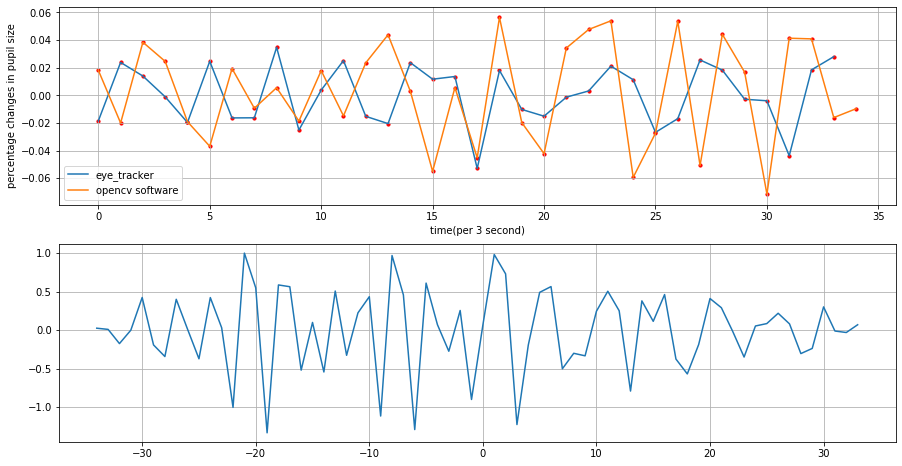

In [34]:
#normalise into 3 second timeframe
df_3 = normalise_sec(df_1, 3)
tdf_3 = normalise_sec(tdf_1, 3)
print('[CHECK] df total ', len(df_3.keys()), ' values for ', list(df_3.keys())[-1], ' second')
print('[CHECK] tdf total ', len(tdf_3.keys()), ' values for ', list(tdf_3.keys())[-1], ' second')
tb_rate_3 = cal_rate(list(tdf_3.values()))
py_rate_3 = cal_rate(list(df_3.values()))[1:]
plot_rate(tb_rate_3, py_rate_3, 3)

## 5 second timeframe (1sec overlap)

[CHECK] df total  19  values for  72  second
[CHECK] tdf total  18  values for  68  second
total matching  9 15 15 0.6 0.6
The cross-correlation score is:  -0.16867852906570355
pearson correlation of eye_tracker (r, p): -0.22635164507058403 0.3992373006040582
pearson correlation of opencv software (r, p): 0.04049592329717683 0.8816295132661912


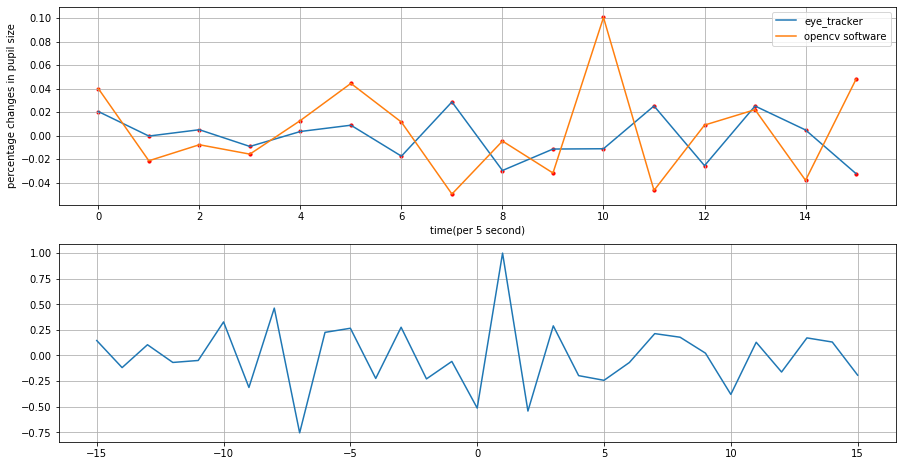

In [35]:
df_5 = normalise_sec(df_1, 5)
tdf_5 = normalise_sec(tdf_1, 5)
print('[CHECK] df total ', len(df_5.keys()), ' values for ', list(df_5.keys())[-1], ' second')
print('[CHECK] tdf total ', len(tdf_5.keys()), ' values for ', list(tdf_5.keys())[-1], ' second')
tb_rate_5 = cal_rate(list(tdf_5.values()))
py_rate_5 = cal_rate(list(df_5.values()))[1:]
plot_rate(tb_rate_5, py_rate_5, 5)

## 10 second timeframe (1sec overlap)

[CHECK] df total  8  values for  63  second
[CHECK] tdf total  8  values for  63  second
total matching  3 5 5 0.6 0.6
The cross-correlation score is:  -0.5099118865175098
pearson correlation of eye_tracker (r, p): -0.13617201553504785 0.7970044831352038
pearson correlation of opencv software (r, p): -0.03962527518608412 0.9405931962801322


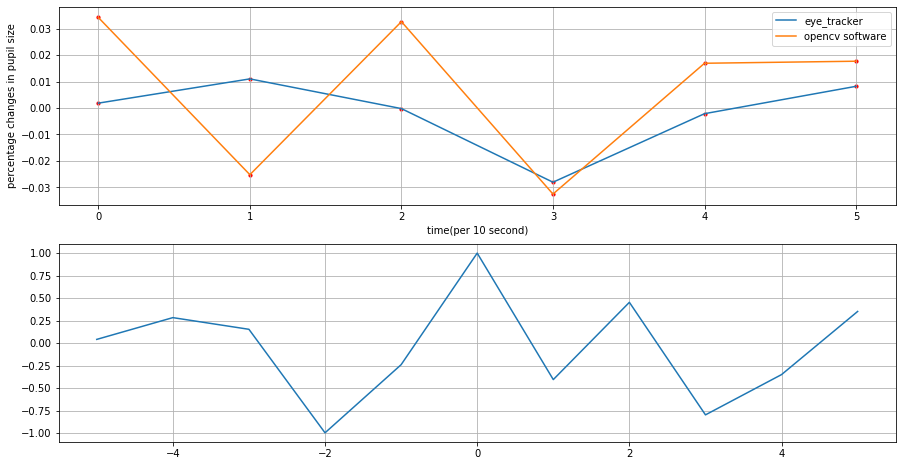

In [38]:
df_10 = normalise_sec(df_1, 10)
tdf_10 = normalise_sec(tdf_1, 10)
print('[CHECK] df total ', len(df_10.keys()), ' values for ', list(df_10.keys())[-1], ' second')
print('[CHECK] tdf total ', len(tdf_10.keys()), ' values for ', list(tdf_10.keys())[-1], ' second')
tb_rate_10 = cal_rate(list(tdf_10.values()))
py_rate_10 = cal_rate(list(df_10.values()))
plot_rate(tb_rate_10, py_rate_10, 10)

## dtw

In [39]:
from dtw import dtw, accelerated_dtw
def cal_dtw(tobii, opencv):
    d1 = [(k, i) for k, i in enumerate(tobii)]
    d2 = [(k, i) for k, i in enumerate(opencv)]

    distance, cost_matrix, acc_cost_matrix, path = accelerated_dtw(d1, d2, dist='euclidean')

    plt.imshow(acc_cost_matrix.T, origin='lower', cmap='gray', interpolation='nearest')
    plt.plot(path[0], path[1], 'w')
    plt.xlabel('tobii')
    plt.ylabel('opencv')
    plt.title(f'DTW Minimum Path with minimum distance: {np.round(distance,2)}')
    plt.show()

1 SEC


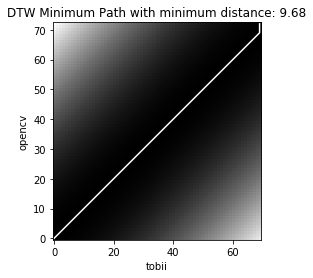

2 SEC


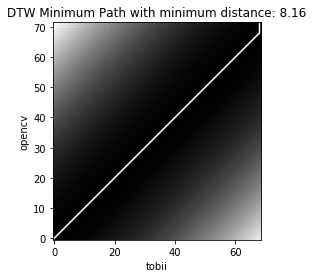

3 SEC


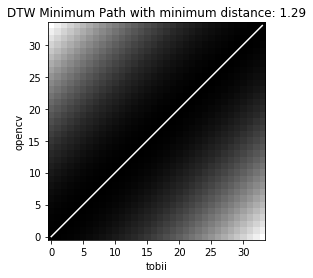

5 SEC


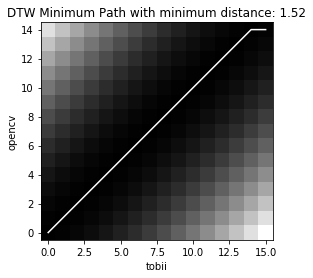

10 SEC


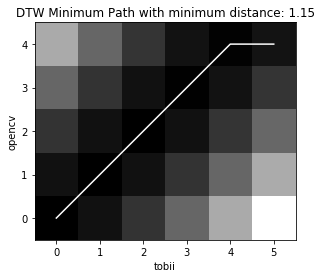

In [40]:
print('1 SEC')
cal_dtw(tb_rate_1, py_rate_1[1:])
print('2 SEC')
cal_dtw(tb_rate_2, py_rate_2[1:])
print('3 SEC')
cal_dtw(tb_rate_3, py_rate_3[1:])
print('5 SEC')
cal_dtw(tb_rate_5, py_rate_5[1:])
print('10 SEC')
cal_dtw(tb_rate_10, py_rate_10[1:])